# Toy hierarchical model

In [6]:
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

import numpy as np
from tqdm import tqdm

import os

from scipy.stats import bootstrap

from coinem.model import AbstractModel
from coinem.dataset import Dataset

## Model

We consider generating data $y$ from a hierarchical Gaussian model with real-valued hyperparameter $\theta = 1$:

$$ p_\theta(x, y) = \mathcal{N}(y; x, I_{D_y}) \mathcal{N}(x; \theta I_{D_y}, I_{D_y}) $$

### Model in code:
To create our model we just inherit from the provided `AbstractModel`.

In [7]:
from jaxtyping import Array, Float, PyTree


@dataclass
class HierarchicalModel(AbstractModel):
    """Base class for p(θ, x)."""
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        log_prob_y_given_x = tfd.MultivariateNormalDiag(jnp.atleast_1d(latent.squeeze())).log_prob(jnp.atleast_1d(data.y.squeeze())).sum() # \mathcal{N}(y; x, I_{D_y}) 
        log_prob_x_given_theta = tfd.Normal(theta, scale=1.0).log_prob(jnp.atleast_1d(latent.squeeze())).sum() # \mathcal{N}(x; \theta I_{D_y}, I_{D_y})

        # Compute log-probability.
        return (log_prob_y_given_x + log_prob_x_given_theta).squeeze() # log p(y|x) + log p(x|theta)
    
    def optimal_theta(self, latent_particles: PyTree[Float[Array, "N D *"]]) -> PyTree[Float[Array, "Q *"]]:
        return latent_particles.mean().reshape(-1) # WARNING: This assumes a single dimension for the "x"!

### Dataset:
We draw one observation $y$ from the model.

In [8]:
Ny = 1
Dy = 100
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

theta_star = jnp.sum(y)/Dy

posterior_mean = 0.5 * (y + theta*jnp.ones_like(y))
posterior_mean_empirical = 0.5 * (y + theta_star * jnp.ones_like(y))

### Unit tests:
We test the score of the latent function and average log-probability of the model.

In [9]:
# Define the model:
model = HierarchicalModel()
data = Dataset(y=y)

# Unit tests:
assert jnp.allclose(model.score_latent(latent, theta, data), (y + theta - 2.0* latent)) # Gradient of log p(y|x) wrt x
assert jnp.allclose(model.score_theta(latent, theta, data), Dy * (latent.mean() - theta)) # Gradient of log p(y|x) wrt theta

### EM algorithm

For this example we can find the EM algorithm in closed form, for the theta updates given below.

In [10]:
def em(model, data, theta, K):
    """Expectation Maximization Algorithm. Returns parameter estimates."""

    def em_step(theta, k):
        new_theta = theta/2.0 + data.y.mean()/2.0
        return new_theta, theta

    _, thetas = jax.lax.scan(em_step, theta, jnp.arange(K))

    return thetas

# Experiment 1 (Step Size Comparison)

We first run all of the methods over a grid of learning rates

In [73]:
# # Run all methods for grid of step sizes
results_dir = "results/toy_model/experiment1"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

#  results in paper
existing_result_id = ["_N_10_init_0_T_500",  # 10 particles, 0 initialisation, 500 iterations (Fig 1: MSE plots)
                      "_N_20_init_0_T_500",  # 20 particles, 0 initialisation, 500 iterations (Fig 6: MSE plots)
                      "_N_50_init_0_T_500",  # 50 particles, 0 initialisation, 500 iterations (Fig 7: MSE plots)
                      "_N_50_init_0_T_100",  # 50 particles, 0 initialisation, 100 iterations (Fig 8: trace plots)
                      "N_50_init_10_T_500"]  # 50 particles, 10 initialisation, 500 iterations (Fig 9: MSE plots)

result_id = "_N_10_init_0_T_500" 
    
from coinem.zoo import coin_svgd, ada_svgd, soul, pgd, ada_pgd, standard_svgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_ada_svgd, marginal_soul, marginal_pgd

step_size_list = jnp.logspace(-5,3,50) # step sizes

n_reps = 10 # number of repeats

if "init_10" in result_id or "T_500" in result_id:
    print("Changing number of iterations to 500")
    K = 500  # number of steps
else:
    K = 100  # number of steps

if "N_10" in result_id:
    N = 10  # number of particles
if "N_20" in result_id:
    N = 20  # number of particles
if "N_50" in result_id:
    N = 50  # number of particles
    

# load = True: load results using the results specified by "result_id"
# load = False: run experiments from scratch
load = True
if load:
    mse_ada_pgd_all = np.load(results_dir + "/" + "mse_ada_pgd" + result_id + ".npy")
    mse_ada_svgd_all = np.load(results_dir + "/" + "mse_ada_svgd" + result_id + ".npy")
    mse_soul_all = np.load(results_dir + "/" + "mse_soul" + result_id + ".npy")
    mse_coin_all = np.load(results_dir + "/" + "mse_coin" + result_id + ".npy")

else:
    mse_ada_pgd_all = np.zeros((n_reps, len(step_size_list)))
    mse_ada_svgd_all = np.zeros((n_reps, len(step_size_list)))
    mse_soul_all = np.zeros((n_reps, len(step_size_list)))
    mse_coin_all = np.zeros(n_reps)
    
    for i, rep in enumerate(range(n_reps)):
        
        print("Repetition: " + str(i+1) + "/" + str(n_reps))
        
        key = jr.PRNGKey(int(i))
        Ny = 1
        Dy = 100
        
        theta = jnp.array([1.0])
        
        key_y, key_latent = jr.split(key)
        latent = theta + jr.normal(key_latent, (1, Dy))
        y = jr.normal(key_y, (Ny, Dy)) + latent
        
        theta_star = jnp.sum(y)/Dy
        
        posterior_mean = 0.5 * (y + theta*jnp.ones_like(y))
        posterior_mean_empirical = 0.5 * (y + theta_star * jnp.ones_like(y))
        
        if "init_10" in result_id:
            th0 = 10 + .1*jr.normal(key, (1,))
        else:
            th0 = .1*jr.normal(key, (1,))
            
        X0 = 1*jr.normal(key, (N, Dy)) 
        
        model = HierarchicalModel()
        data = Dataset(y=y)
        
        for j, step in enumerate(step_size_list):
            if (j+1) % 10 == 0: 
                print("Step: " + str(j+1) + "/" + str(len(step_size_list)))
            _, theta_ada_pgd = ada_pgd(model, data, X0, th0, K, latent_step_size = step, theta_step_size = step)
            _, theta_ada_svgd = ada_svgd(model, data, X0, th0, K, theta_step_size = step, latent_step_size = step)
            _, theta_soul = soul(model, data, X0, th0, K, theta_step_size = step, latent_step_size = step)
            
            # can average pgd and soul after burn-in, for fair comparison between methods we always compare last iterate
            # empirically, averaging over t doesn't seem to meaningfully change the results, given we are also averaging over multiple runs
            if "average" in result_id: 
                mse_ada_pgd = (np.mean(theta_ada_pgd[-100:]) - theta_star)**2
                mse_ada_svgd = (theta_ada_svgd[-1] - theta_star)**2
                mse_soul = (np.mean(theta_soul[-100:]) - theta_star)**2
                
            else:
                mse_ada_pgd = (theta_ada_pgd[-1] - theta_star)**2
                mse_ada_svgd = (theta_ada_svgd[-1] - theta_star)**2
                mse_soul = (theta_soul[-1] - theta_star)**2
            
            mse_ada_pgd_all[i,j] = mse_ada_pgd
            mse_ada_svgd_all[i,j] = mse_ada_svgd
            mse_soul_all[i,j] = mse_soul
            
        _, theta_coin = coin_svgd(model, data, X0, th0, K)
        mse_coin = (theta_coin[-1] - theta_star) ** 2
        mse_coin_all[i] = mse_coin

    save = True
    if save:
        np.save(results_dir + "/" + "mse_ada_pgd" + result_id, mse_ada_pgd_all)
        np.save(results_dir + "/" + "mse_ada_svgd" + result_id, mse_ada_svgd_all)
        np.save(results_dir + "/" + "mse_soul" + result_id, mse_soul_all)
        np.save(results_dir + "/" + "mse_coin" + result_id, mse_coin_all)

Changing number of iterations to 500


# Fig. 1 (Sec 4.1) and Fig. 6, 7, 9 (App. F.1)

### (a) MSE vs Learning Rate

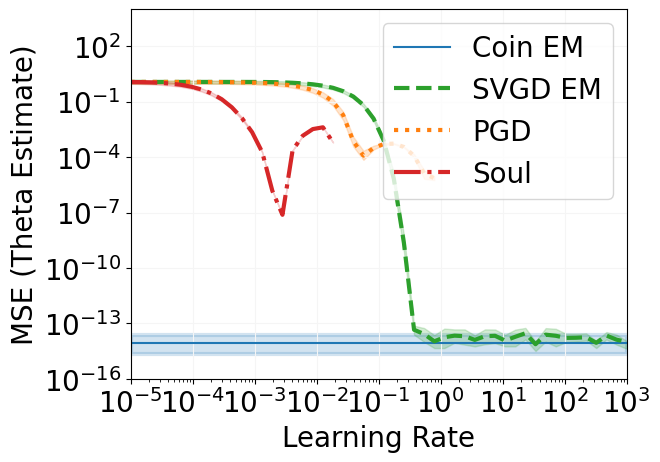

In [86]:
# Set up directory
fig_dir = "figures/toy_model/experiment1"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# compute confidence intervals
data_ada_pgd = (mse_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (mse_ada_svgd_all,) 
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (mse_soul_all,) 
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,) 
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.axhline(np.mean(mse_coin_all), color="C0", label="Coin EM")
plt.fill_between(step_size_list, res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=3)

plt.plot(step_size_list, np.mean(mse_ada_svgd_all,0), color="C2", linestyle='dashed', label="SVGD EM", linewidth=3)
plt.fill_between(step_size_list, res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], alpha=0.2, color="C2")

plt.plot(step_size_list, np.mean(mse_ada_pgd_all,0), color="C1", linestyle='dotted', label="PGD", linewidth=3)
plt.fill_between(step_size_list, res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], alpha=0.2, color="C1")

plt.plot(step_size_list, np.mean(mse_soul_all,0), color="C3", linestyle='dashdot', label="Soul", linewidth=3)
plt.fill_between(step_size_list, res_soul.confidence_interval[0], res_soul.confidence_interval[1], alpha=0.2, color="C3")

plt.ylim(1e-16,10000)
plt.xscale("log")
plt.yscale("log") 
plt.legend(loc='upper right',prop={'size': 20})
plt.margins(x=0)
plt.xlabel("Learning Rate", fontsize=20)
plt.ylabel("MSE (Theta Estimate)", fontsize=20)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_lr_vs_theta_mse" + result_id + ".pdf",dpi=300, bbox_inches='tight')

### (a) MSE vs Iterations (Optimal Learning Rate)

Using these results, we can compute an "optimal" step size for each method.

In [50]:
# compute the optimal step sizes
load = True
if load:
    lr_opt_ada_pgd = np.load(results_dir + "/" + "lr_opt_ada_pgd" + result_id + ".npy")
    lr_opt_ada_svgd = np.load(results_dir + "/" + "lr_opt_ada_svgd" + result_id + ".npy")
    lr_opt_soul = np.load(results_dir + "/" + "lr_opt_soul" + result_id + ".npy")
    
    lr_small_ada_pgd = np.load(results_dir + "/" + "lr_small_ada_pgd" + result_id + ".npy")
    lr_small_ada_svgd = np.load(results_dir + "/" + "lr_small_ada_svgd" + result_id + ".npy")
    lr_small_soul = np.load(results_dir + "/" + "lr_small_soul" + result_id + ".npy")
    
    lr_big_ada_pgd = np.load(results_dir + "/" + "lr_big_ada_pgd" + result_id + ".npy")
    lr_big_ada_svgd = np.load(results_dir + "/" + "lr_big_ada_svgd" + result_id + ".npy")
    lr_big_soul = np.load(results_dir + "/" + "lr_big_soul" + result_id + ".npy")


else:
    mse_ada_pgd = np.mean(mse_ada_pgd_all,axis=0) # mean over reps
    mse_ada_svgd = np.mean(mse_ada_svgd_all,axis=0) # mean over reps
    mse_soul = np.mean(mse_soul_all, axis=0) # mean over reps
    
    lr_opt_ada_pgd_id = np.nanargmin(mse_ada_pgd)
    lr_opt_ada_svgd_id = np.nanargmin(mse_ada_svgd)
    lr_opt_soul_id = np.nanargmin(mse_soul)
    
    lr_opt_ada_pgd = step_size_list[lr_opt_ada_pgd_id]
    lr_opt_ada_svgd = step_size_list[lr_opt_ada_svgd_id]
    lr_opt_soul = step_size_list[lr_opt_soul_id]

    lr_small_ada_pgd = step_size_list[lr_opt_ada_pgd_id - 8]
    lr_small_ada_svgd = step_size_list[lr_opt_ada_svgd_id - 8]
    lr_small_soul = step_size_list[lr_opt_soul_id - 8]
    
    # determine these from the MSE vs LR plot
    
    lr_big_ada_pgd = step_size_list[np.isnan(mse_ada_pgd).argmax()] #step_size_list[lr_opt_ada_pgd_id + 1]
    lr_big_ada_svgd = 1e2 #step_size_list[lr_opt_ada_svgd_id + 1]
    lr_big_soul = step_size_list[np.isnan(mse_soul).argmax() - 1] #step_size_list[lr_opt_soul_id + 1]
    
    print("Optimal LR (Adagrad-PGD): " + str(lr_opt_ada_pgd))
    print("Optimal LR (Adagrad-SVGD): " + str(lr_opt_ada_svgd))
    print("Optimal LR (SOUL): " + str(lr_opt_soul))
    
    print("Small LR (Adagrad-PGD): " + str(lr_small_ada_pgd))
    print("Small LR (Adagrad-SVGD): " + str(lr_small_ada_svgd))
    print("Small LR (SOUL): " + str(lr_small_soul))
    
    print("Big LR (Adagrad-PGD): " + str(lr_big_ada_pgd))
    print("Big LR (Adagrad-SVGD): " + str(lr_big_ada_svgd))
    print("Big LR (SOUL): " + str(lr_big_soul))

    save = True
    if save:
        np.save(results_dir + "/" + "lr_opt_ada_pgd" + result_id, lr_opt_ada_pgd)
        np.save(results_dir + "/" + "lr_opt_ada_svgd" + result_id, lr_opt_ada_svgd)
        np.save(results_dir + "/" + "lr_opt_soul" + result_id, lr_opt_soul)
        
        np.save(results_dir + "/" + "lr_small_ada_pgd" + result_id, lr_small_ada_pgd)
        np.save(results_dir + "/" + "lr_small_ada_svgd" + result_id, lr_small_ada_svgd)
        np.save(results_dir + "/" + "lr_small_soul" + result_id, lr_small_soul)
        
        np.save(results_dir + "/" + "lr_big_ada_pgd" + result_id, lr_big_ada_pgd)
        np.save(results_dir + "/" + "lr_big_ada_svgd" + result_id, lr_big_ada_svgd)
        np.save(results_dir + "/" + "lr_big_soul" + result_id, lr_big_soul)

We'll use these learning rates to run each method, now storing the results for all iterations.

In [51]:
# run all methods for the optimal step sizes
load = True
if load:
    if "init_10" in result_id or "T_500" in result_id:
        K = 500
    else:
        K = 100
        
    # theta
    th_em_all = np.load(results_dir + "/" + "theta_em_all_opt_lr" + result_id + ".npy")
    
    th_ada_pgd_all_small = np.load(results_dir + "/" + "theta_ada_pgd_all_small_lr" + result_id + ".npy")
    th_ada_svgd_all_small = np.load(results_dir + "/" + "theta_ada_svgd_all_small_lr" + result_id + ".npy")
    th_soul_all_small = np.load(results_dir + "/" + "theta_soul_all_small_lr" + result_id + ".npy")
    
    th_ada_pgd_all_big = np.load(results_dir + "/" + "theta_ada_pgd_all_big_lr" + result_id + ".npy")
    th_ada_svgd_all_big = np.load(results_dir + "/" + "theta_ada_svgd_all_big_lr" + result_id + ".npy")
    th_soul_all_big = np.load(results_dir + "/" + "theta_soul_all_big_lr" + result_id + ".npy")
    
    th_ada_pgd_all = np.load(results_dir + "/" + "theta_ada_pgd_all_opt_lr" + result_id + ".npy")
    th_ada_svgd_all = np.load(results_dir + "/" + "theta_ada_svgd_all_opt_lr" + result_id + ".npy")
    th_soul_all = np.load(results_dir + "/" + "theta_soul_all_opt_lr" + result_id + ".npy")
    
    th_coin_all = np.load(results_dir + "/" + "theta_coin_all_opt_lr" + result_id + ".npy")
    
    # latent
    x_ada_pgd_all_small = np.load(results_dir + "/" + "x_ada_pgd_all_small_lr" + result_id + ".npy")
    x_ada_svgd_all_small = np.load(results_dir + "/" + "x_ada_svgd_all_small_lr" + result_id + ".npy")
    x_soul_all_small = np.load(results_dir + "/" + "x_soul_all_small_lr" + result_id + ".npy")
    
    x_ada_pgd_all_big = np.load(results_dir + "/" + "x_ada_pgd_all_big_lr" + result_id + ".npy")
    x_ada_svgd_all_big = np.load(results_dir + "/" + "x_ada_svgd_all_big_lr" + result_id + ".npy")
    x_soul_all_big = np.load(results_dir + "/" + "x_soul_all_big_lr" + result_id + ".npy")
    
    x_ada_pgd_all = np.load(results_dir + "/" + "x_ada_pgd_all_opt_lr" + result_id + ".npy")
    x_ada_svgd_all = np.load(results_dir + "/" + "x_ada_svgd_all_opt_lr" + result_id + ".npy")
    x_soul_all = np.load(results_dir + "/" + "x_soul_all_opt_lr" + result_id + ".npy")
    
    x_coin_all = np.load(results_dir + "/" + "x_coin_all_opt_lr" + result_id + ".npy")
    
    
    # mse theta
    mse_ada_pgd_all_small = np.load(results_dir + "/" + "mse_ada_pgd_all_small_lr" + result_id + ".npy")
    mse_ada_svgd_all_small = np.load(results_dir + "/" + "mse_ada_svgd_all_small_lr" + result_id + ".npy")
    mse_soul_all_small = np.load(results_dir + "/" + "mse_soul_all_small_lr" + result_id + ".npy")

    mse_ada_pgd_all_big = np.load(results_dir + "/" + "mse_ada_pgd_all_big_lr" + result_id + ".npy")
    mse_ada_svgd_all_big = np.load(results_dir + "/" + "mse_ada_svgd_all_big_lr" + result_id + ".npy")
    mse_soul_all_big = np.load(results_dir + "/" + "mse_soul_all_big_lr" + result_id + ".npy")

    mse_ada_pgd_all = np.load(results_dir + "/" + "mse_ada_pgd_all_opt_lr" + result_id + ".npy")
    mse_ada_svgd_all = np.load(results_dir + "/" + "mse_ada_svgd_all_opt_lr" + result_id + ".npy")
    mse_soul_all = np.load(results_dir + "/" + "mse_soul_all_opt_lr" + result_id + ".npy")

    mse_coin_all = np.load(results_dir + "/" + "mse_coin_all_opt_lr" + result_id + ".npy")

    
    # mse latent
    mse_latent_ada_pgd_all_small = np.load(results_dir + "/" + "mse_latent_ada_pgd_all_small_lr" + result_id + ".npy")
    mse_latent_ada_svgd_all_small = np.load(results_dir + "/" + "mse_latent_ada_svgd_all_small_lr" + result_id + ".npy")
    mse_latent_soul_all_small = np.load(results_dir + "/" + "mse_latent_soul_all_small_lr" + result_id + ".npy")

    mse_latent_ada_pgd_all_big = np.load(results_dir + "/" + "mse_latent_ada_pgd_all_big_lr" + result_id + ".npy")
    mse_latent_ada_svgd_all_big = np.load(results_dir + "/" + "mse_latent_ada_svgd_all_big_lr" + result_id + ".npy")
    mse_latent_soul_all_big = np.load(results_dir + "/" + "mse_latent_soul_all_big_lr" + result_id + ".npy")

    mse_latent_ada_pgd_all = np.load(results_dir + "/" + "mse_latent_ada_pgd_all_opt_lr" + result_id + ".npy")
    mse_latent_ada_svgd_all = np.load(results_dir + "/" + "mse_latent_ada_svgd_all_opt_lr" + result_id + ".npy")
    mse_latent_soul_all = np.load(results_dir + "/" + "mse_latent_soul_all_opt_lr" + result_id + ".npy")

    mse_latent_coin_all = np.load(results_dir + "/" + "mse_latent_coin_all_opt_lr" + result_id + ".npy")

    theta_star_all = np.load(results_dir + "/" + "theta_star_all" + result_id + ".npy")
    
else:
    
    n_reps = 10
    
    if "init_10" in result_id or "T_500" in result_id:
        K = 500
    else:
        K = 100
    
    # Optimal LR
    th_em_all, x_mean_em_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    th_ada_pgd_all, x_ada_pgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    th_ada_svgd_all, x_ada_svgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    th_soul_all, x_soul_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    
    mse_ada_pgd_all, mse_latent_ada_pgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_ada_svgd_all, mse_latent_ada_svgd_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_soul_all, mse_latent_soul_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_coin_all, mse_latent_coin_all = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    
    # Small LR
    th_ada_pgd_all_small, x_ada_pgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    th_ada_svgd_all_small, x_ada_svgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    th_soul_all_small, x_soul_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    
    mse_ada_pgd_all_small, mse_latent_ada_pgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_ada_svgd_all_small, mse_latent_ada_svgd_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_soul_all_small, mse_latent_soul_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_coin_all_small, mse_latent_coin_all_small = np.zeros((n_reps, K)), np.zeros((n_reps, K))

    # Big LR
    th_ada_pgd_all_big, x_ada_pgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    th_ada_svgd_all_big, x_ada_svgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    th_soul_all_big, x_soul_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    
    mse_ada_pgd_all_big, mse_latent_ada_pgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_ada_svgd_all_big, mse_latent_ada_svgd_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_soul_all_big, mse_latent_soul_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    mse_coin_all_big, mse_latent_coin_all_big = np.zeros((n_reps, K)), np.zeros((n_reps, K))
    
    # Coin 
    th_coin_all, x_coin_all = np.zeros((n_reps, K)), np.zeros((n_reps, K, N, Dy))
    
    # Parameters
    theta_star_all = np.zeros((n_reps))
    posterior_mean_empirical_all = np.zeros((n_reps, Dy))

    for i, rep in enumerate(range(n_reps)):
        
        print("Repetition: " + str(i+1) + "/" + str(n_reps))
        
        # Setup Model
        key = jr.PRNGKey(int(i))
        Ny = 1
        Dy = 100
        
        theta = jnp.array([1.0])
        
        key_y, key_latent = jr.split(key)
        latent = theta + jr.normal(key_latent, (1, Dy))
        y = jr.normal(key_y, (Ny, Dy)) + latent
        
        theta_star = jnp.sum(y)/Dy
        
        theta_star_all[i] = theta_star
        
        posterior_mean = 0.5 * (y + theta*jnp.ones_like(y))
        posterior_mean_empirical = 0.5 * (y + theta_star * jnp.ones_like(y))
        
        posterior_mean_empirical_all[i, :] = posterior_mean_empirical
        
        if "init_10" in result_id:
            th0 = 10 + .1*jr.normal(key, (1,))
        else:
            th0 = .1*jr.normal(key, (1,))
            
        X0 = 1*jr.normal(key, (N, Dy)) 
        
        model = HierarchicalModel()
        data = Dataset(y=y)

        # EM
        th_em = em(model, data, th0, K)
        x_mean_em = (data.y.squeeze()  + th_em)
        th_em_all[i, :] = th_em.squeeze()
        
        # optimal LR
        x_ada_pgd, th_ada_pgd = ada_pgd(model, data, X0, th0, K, latent_step_size=lr_opt_ada_pgd, theta_step_size=lr_opt_ada_pgd)
        x_ada_svgd, th_ada_svgd = ada_svgd(model, data, X0, th0, K, theta_step_size=lr_opt_ada_svgd, latent_step_size=lr_opt_ada_svgd)
        x_soul, th_soul = soul(model, data, X0, th0, K, theta_step_size=lr_opt_soul, latent_step_size=lr_opt_soul)
        
        if "average" in result_id:
            mse_ada_pgd = (np.cumsum(th_ada_pgd)/np.arange(1,K+1) - theta_star)**2
            mse_ada_svgd = (th_ada_svgd - theta_star)**2 # never average svgd!
            mse_soul = (np.cumsum(th_soul)/np.arange(1,K+1) - theta_star)**2
        else:
            mse_ada_pgd = (th_ada_pgd - theta_star)**2
            mse_ada_svgd = (th_ada_svgd - theta_star)**2
            mse_soul = (th_soul - theta_star)**2
        
        mse_latent_ada_pgd = ((x_ada_pgd.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        mse_latent_ada_svgd = ((x_ada_svgd.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        mse_latent_soul = ((x_soul.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        
        x_ada_pgd_all[i, :, :, :], th_ada_pgd_all[i, :] = x_ada_pgd, th_ada_pgd.squeeze()
        x_ada_svgd_all[i, :, :, :], th_ada_svgd_all[i, :] = x_ada_svgd, th_ada_svgd.squeeze()
        x_soul_all[i, :, :, :], th_soul_all[i, :] = x_soul, th_soul.squeeze()
        
        mse_ada_pgd_all[i,:] = mse_ada_pgd.squeeze()
        mse_ada_svgd_all[i,:] = mse_ada_svgd.squeeze()
        mse_soul_all[i,:] = mse_soul.squeeze()
        
        mse_latent_ada_pgd_all[i,:] = mse_latent_ada_pgd.squeeze()
        mse_latent_ada_svgd_all[i,:] = mse_latent_ada_svgd.squeeze()
        mse_latent_soul_all[i,:] = mse_latent_soul.squeeze()
        
        # small LR
        x_ada_pgd_small, th_ada_pgd_small = ada_pgd(model, data, X0, th0, K, latent_step_size=lr_small_ada_pgd, theta_step_size=lr_small_ada_pgd)
        x_ada_svgd_small, th_ada_svgd_small = ada_svgd(model, data, X0, th0, K, theta_step_size=lr_small_ada_svgd, latent_step_size=lr_small_ada_svgd)
        x_soul_small, th_soul_small = soul(model, data, X0, th0, K, theta_step_size=lr_small_soul, latent_step_size=lr_small_soul)
        
        if "average" in result_id:
            mse_ada_pgd_small = (np.cumsum(th_ada_pgd_small)/np.arange(1,K+1) - theta_star)**2
            mse_ada_svgd_small = (th_ada_svgd_small - theta_star)**2
            mse_soul_small = (np.cumsum(th_soul_small)/np.arange(1,K+1) - theta_star)**2
        else:
            mse_ada_pgd_small = (th_ada_pgd_small - theta_star)**2
            mse_ada_svgd_small = (th_ada_svgd_small - theta_star)**2
            mse_soul_small = (th_soul_small - theta_star)**2
        
        mse_latent_ada_pgd_small = ((x_ada_pgd_small.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        mse_latent_ada_svgd_small = ((x_ada_svgd_small.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        mse_latent_soul_small = ((x_soul_small.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        
        x_ada_pgd_all_small[i, :, :, :], th_ada_pgd_all_small[i, :] = x_ada_pgd_small, th_ada_pgd_small.squeeze()
        x_ada_svgd_all_small[i, :, :, :], th_ada_svgd_all_small[i, :] = x_ada_svgd_small, th_ada_svgd_small.squeeze()
        x_soul_all_small[i, :, :, :], th_soul_all_small[i, :] = x_soul_small, th_soul_small.squeeze()
        
        mse_ada_pgd_all_small[i,:] = mse_ada_pgd_small.squeeze()
        mse_ada_svgd_all_small[i,:] = mse_ada_svgd_small.squeeze()
        mse_soul_all_small[i,:] = mse_soul_small.squeeze()
        
        mse_latent_ada_pgd_all_small[i,:] = mse_latent_ada_pgd_small.squeeze()
        mse_latent_ada_svgd_all_small[i,:] = mse_latent_ada_svgd_small.squeeze()
        mse_latent_soul_all_small[i,:] = mse_latent_soul_small.squeeze()
        
        # big LR
        x_ada_pgd_big, th_ada_pgd_big = ada_pgd(model, data, X0, th0, K, latent_step_size=lr_big_ada_pgd, theta_step_size=lr_big_ada_pgd)
        x_ada_svgd_big, th_ada_svgd_big = ada_svgd(model, data, X0, th0, K, theta_step_size=lr_big_ada_svgd, latent_step_size=lr_big_ada_svgd)
        x_soul_big, th_soul_big = soul(model, data, X0, th0, K, theta_step_size=lr_big_soul, latent_step_size=lr_big_soul)
        
        if "average" in result_id:
            mse_ada_pgd_big = (np.cumsum(th_ada_pgd_big)/np.arange(1,K+1) - theta_star)**2
            mse_ada_svgd_big = (th_ada_svgd_big - theta_star)**2
            mse_soul_big = (np.cumsum(th_soul_big)/np.arange(1,K+1) - theta_star)**2
        else:   
            mse_ada_pgd_big = (th_ada_pgd_big - theta_star)**2
            mse_ada_svgd_big = (th_ada_svgd_big - theta_star)**2
            mse_soul_big = (th_soul_big - theta_star)**2
    
        
        mse_latent_ada_pgd_big = ((x_ada_pgd_big.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        mse_latent_ada_svgd_big = ((x_ada_svgd_big.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        mse_latent_soul_big = ((x_soul_big.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        
        x_ada_pgd_all_big[i, :, :, :], th_ada_pgd_all_big[i, :] = x_ada_pgd_big, th_ada_pgd_big.squeeze()
        x_ada_svgd_all_big[i, :, :, :], th_ada_svgd_all_big[i, :] = x_ada_svgd_big, th_ada_svgd_big.squeeze()
        x_soul_all_big[i, :, :, :], th_soul_all_big[i, :] = x_soul_big, th_soul_big.squeeze()
        
        mse_ada_pgd_all_big[i,:] = mse_ada_pgd_big.squeeze()
        mse_ada_svgd_all_big[i,:] = mse_ada_svgd_big.squeeze()
        mse_soul_all_big[i,:] = mse_soul_big.squeeze()
        
        mse_latent_ada_pgd_all_big[i,:] = mse_latent_ada_pgd_big.squeeze()
        mse_latent_ada_svgd_all_big[i,:] = mse_latent_ada_svgd_big.squeeze()
        mse_latent_soul_all_big[i,:] = mse_latent_soul_big.squeeze()
        
        # Coin 
        x_coin, th_coin = coin_svgd(model, data, X0, th0, K)
        mse_coin = (th_coin - theta_star) ** 2
        mse_latent_coin = ((x_coin.mean(axis=1) - posterior_mean_empirical[:,np.newaxis])**2).mean(axis=2)
        x_coin_all[i, :, :, :], th_coin_all[i, :] = x_coin, th_coin.squeeze()
        mse_coin_all[i, :] = mse_coin.squeeze()
        mse_latent_coin_all[i,:] = mse_latent_coin.squeeze()
        
        
    save = True
    if save:
        # theta
        np.save(results_dir + "/" + "theta_em_all_opt_lr" + result_id, th_em_all)
        
        np.save(results_dir + "/" + "theta_ada_pgd_all_small_lr" + result_id, th_ada_pgd_all_small)
        np.save(results_dir + "/" + "theta_ada_svgd_all_small_lr" + result_id, th_ada_svgd_all_small)
        np.save(results_dir + "/" + "theta_soul_all_small_lr" + result_id, th_soul_all_small)
        
        np.save(results_dir + "/" + "theta_ada_pgd_all_big_lr" + result_id, th_ada_pgd_all_big)
        np.save(results_dir + "/" + "theta_ada_svgd_all_big_lr" + result_id, th_ada_svgd_all_big)
        np.save(results_dir + "/" + "theta_soul_all_big_lr" + result_id, th_soul_all_big)
        
        np.save(results_dir + "/" + "theta_ada_pgd_all_opt_lr" + result_id, th_ada_pgd_all)
        np.save(results_dir + "/" + "theta_ada_svgd_all_opt_lr" + result_id, th_ada_svgd_all)
        np.save(results_dir + "/" + "theta_soul_all_opt_lr" + result_id, th_soul_all)
        
        np.save(results_dir + "/" + "theta_coin_all_opt_lr" + result_id, th_coin_all)
        
        
        np.save(results_dir + "/" + "x_ada_pgd_all_small_lr" + result_id, x_ada_pgd_all_small)
        np.save(results_dir + "/" + "x_ada_svgd_all_small_lr" + result_id, x_ada_svgd_all_small)
        np.save(results_dir + "/" + "x_soul_all_small_lr" + result_id, x_soul_all_small)
        
        np.save(results_dir + "/" + "x_ada_pgd_all_big_lr" + result_id, x_ada_pgd_all_big)
        np.save(results_dir + "/" + "x_ada_svgd_all_big_lr" + result_id, x_ada_svgd_all_big)
        np.save(results_dir + "/" + "x_soul_all_big_lr" + result_id, x_soul_all_big)
        
        np.save(results_dir + "/" + "x_ada_pgd_all_opt_lr" + result_id, x_ada_pgd_all)
        np.save(results_dir + "/" + "x_ada_svgd_all_opt_lr" + result_id, x_ada_svgd_all)
        np.save(results_dir + "/" + "x_soul_all_opt_lr" + result_id, x_soul_all)
        
        np.save(results_dir + "/" + "x_coin_all_opt_lr" + result_id, x_coin_all)
        
        
        np.save(results_dir + "/" + "mse_ada_pgd_all_small_lr" + result_id, mse_ada_pgd_all_small)
        np.save(results_dir + "/" + "mse_ada_svgd_all_small_lr" + result_id, mse_ada_svgd_all_small)
        np.save(results_dir + "/" + "mse_soul_all_small_lr" + result_id, mse_soul_all_small)
        
        np.save(results_dir + "/" + "mse_ada_pgd_all_big_lr" + result_id, mse_ada_pgd_all_big)
        np.save(results_dir + "/" + "mse_ada_svgd_all_big_lr" + result_id, mse_ada_svgd_all_big)
        np.save(results_dir + "/" + "mse_soul_all_big_lr" + result_id, mse_soul_all_big)
        
        np.save(results_dir + "/" + "mse_ada_pgd_all_opt_lr" + result_id, mse_ada_pgd_all)
        np.save(results_dir + "/" + "mse_ada_svgd_all_opt_lr" + result_id, mse_ada_svgd_all)
        np.save(results_dir + "/" + "mse_soul_all_opt_lr" + result_id, mse_soul_all)
        
        np.save(results_dir + "/" + "mse_coin_all_opt_lr" + result_id, mse_coin_all)
        
        
        np.save(results_dir + "/" + "mse_latent_ada_pgd_all_small_lr" + result_id, mse_latent_ada_pgd_all_small)
        np.save(results_dir + "/" + "mse_latent_ada_svgd_all_small_lr" + result_id, mse_latent_ada_svgd_all_small)
        np.save(results_dir + "/" + "mse_latent_soul_all_small_lr" + result_id, mse_latent_soul_all_small)
        
        np.save(results_dir + "/" + "mse_latent_ada_pgd_all_big_lr" + result_id, mse_latent_ada_pgd_all_big)
        np.save(results_dir + "/" + "mse_latent_ada_svgd_all_big_lr" + result_id, mse_latent_ada_svgd_all_big)
        np.save(results_dir + "/" + "mse_latent_soul_all_big_lr" + result_id, mse_latent_soul_all_big)
        
        np.save(results_dir + "/" + "mse_latent_ada_pgd_all_opt_lr" + result_id, mse_latent_ada_pgd_all)
        np.save(results_dir + "/" + "mse_latent_ada_svgd_all_opt_lr" + result_id, mse_latent_ada_svgd_all)
        np.save(results_dir + "/" + "mse_latent_soul_all_opt_lr" + result_id, mse_latent_soul_all)
        
        np.save(results_dir + "/" + "mse_latent_coin_all_opt_lr" + result_id, mse_latent_coin_all)
        
        np.save(results_dir + "/" + "theta_star_all" + result_id, theta_star_all)
        
    

### (b) MSE vs Iterations (Theta)

We now plot MSE vs iterations, using the optimal LR.

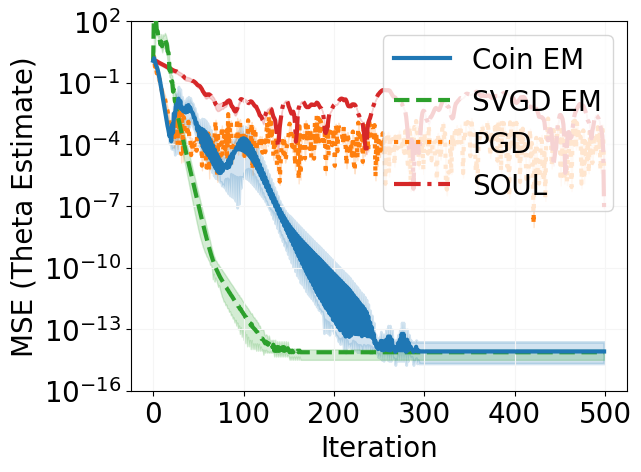

In [52]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_ada_pgd = np.mean(mse_ada_pgd_all,axis=0) # mean over reps
mse_ada_svgd = np.mean(mse_ada_svgd_all,axis=0) # mean over reps
mse_soul = np.mean(mse_soul_all, axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (mse_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (mse_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9, n_resamples=100)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_ada_svgd, zorder=8, color="C2", label="SVGD EM", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_ada_pgd, color="C1", label="PGD", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_soul, color="C3", label="SOUL", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 20})
plt.xlabel('Iteration', fontsize=20)
plt.ylabel("MSE (Theta Estimate)", fontsize=20)
plt.yscale("log")
plt.ylim(1e-16,10e1)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_theta_mse" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()

### (c) MSE vs Iterations (Latent)

Finally, we plot the MSE of the posterior mean vs the iterations.

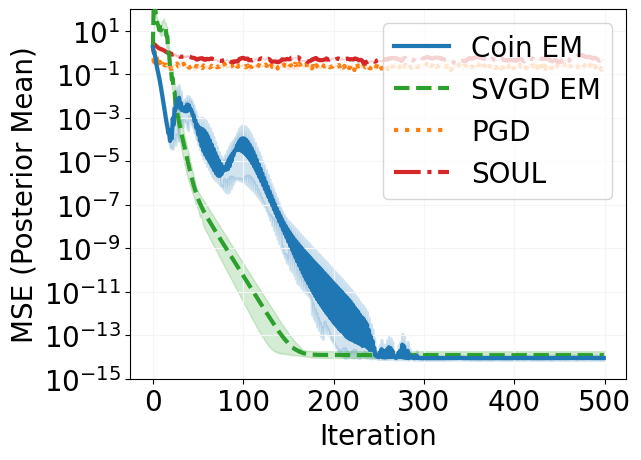

In [53]:
# Plot MSE (theta) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_ada_pgd = np.mean(mse_latent_ada_pgd_all,axis=0) # mean over reps
mse_latent_ada_svgd = np.mean(mse_latent_ada_svgd_all,axis=0) # mean over reps
mse_latent_soul = np.mean(mse_latent_soul_all, axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_latent_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_svgd = (mse_latent_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_soul = (mse_latent_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9, n_resamples=100)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_ada_svgd, zorder=8, color="C2", label="SVGD EM", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_ada_pgd, color="C1", label="PGD", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_soul, color="C3", label="SOUL", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 20})
plt.xlabel('Iteration', fontsize=20)
plt.ylabel("MSE (Posterior Mean)", fontsize=20)
plt.yscale("log")
plt.ylim(1e-15,10e1)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_latent_mse" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()

# Figure 8 (App. F.1)

### (a) SVGD EM vs Coin EM (Different LRs)

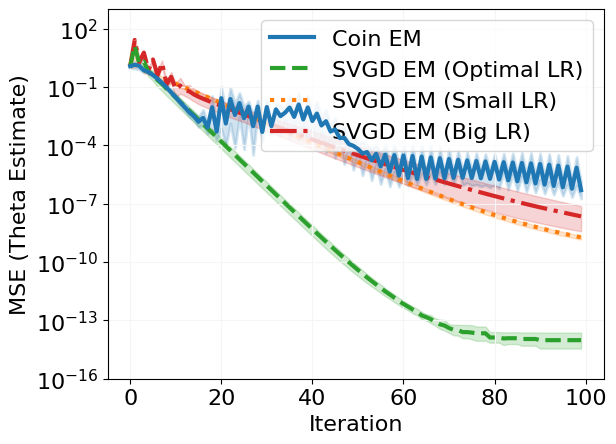

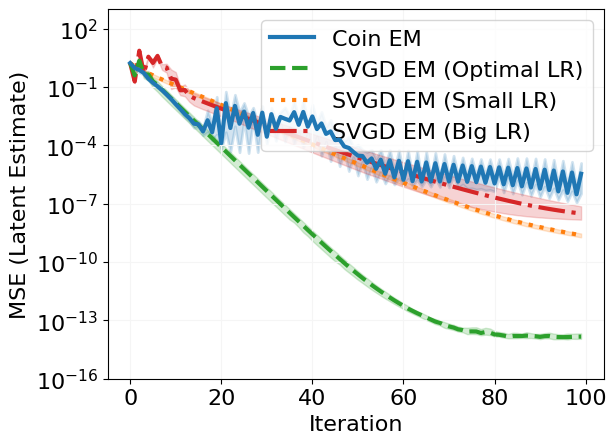

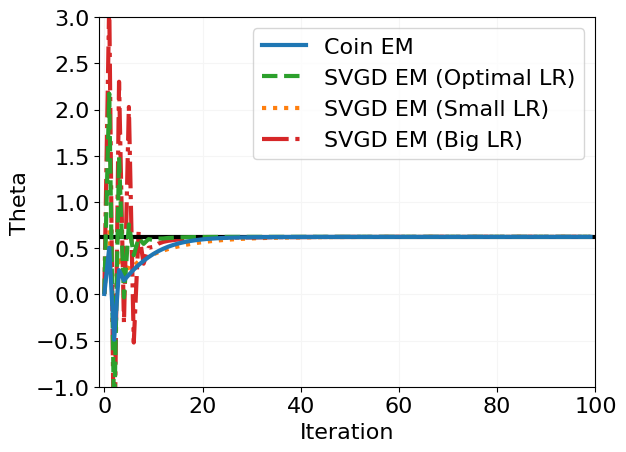

In [45]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_ada_svgd = np.mean(mse_ada_svgd_all,axis=0) # mean over reps
mse_ada_svgd_small = np.mean(mse_ada_svgd_all_small,axis=0) # mean over reps
mse_ada_svgd_big = np.mean(mse_ada_svgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_svgd = (mse_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_ada_svgd_small = (mse_ada_svgd_all_small,)  # samples must be in a sequence
res_ada_svgd_small = bootstrap(data_ada_svgd_small, np.mean, confidence_level=0.9)

data_ada_svgd_big = (mse_ada_svgd_all_big,)  # samples must be in a sequence
res_ada_svgd_big = bootstrap(data_ada_svgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_ada_svgd, zorder=8, color="C2", label="SVGD EM (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_ada_svgd_small, color="C1", label="SVGD EM (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_svgd_small.confidence_interval[0], res_ada_svgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_ada_svgd_big, color="C3", label="SVGD EM (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_svgd_big.confidence_interval[0], res_ada_svgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Theta Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
    
save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_theta_mse_svgd_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()



# Plot MSE (latent) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_ada_svgd = np.mean(mse_latent_ada_svgd_all,axis=0) # mean over reps
mse_latent_ada_svgd_small = np.mean(mse_latent_ada_svgd_all_small,axis=0) # mean over reps
mse_latent_ada_svgd_big = np.mean(mse_latent_ada_svgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_svgd = (mse_latent_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_ada_svgd_small = (mse_latent_ada_svgd_all_small,)  # samples must be in a sequence
res_ada_svgd_small = bootstrap(data_ada_svgd_small, np.mean, confidence_level=0.9)

data_ada_svgd_big = (mse_latent_ada_svgd_all_big,)  # samples must be in a sequence
res_ada_svgd_big = bootstrap(data_ada_svgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_ada_svgd, zorder=8, color="C2", label="SVGD EM (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_ada_svgd_small, color="C1", label="SVGD EM (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_svgd_small.confidence_interval[0], res_ada_svgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_ada_svgd_big, color="C3", label="SVGD EM (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_svgd_big.confidence_interval[0], res_ada_svgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Latent Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
    
save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_latent_mse_svgd_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()



# Plot theta vs iterations (illustrative run)

#th_coin = np.mean(th_coin_all, axis=0)
#th_svgd = np.mean(th_ada_svgd_all,axis=0) # mean over reps
#th_svgd_small = np.mean(th_ada_svgd_all_small,axis=0) # mean over reps
#th_svgd_big = np.mean(th_ada_svgd_all_big,axis=0) # mean over reps
which_rep = 6
th_coin = th_coin_all[which_rep,:]
th_svgd = th_ada_svgd_all[which_rep,:]
th_svgd_small = th_ada_svgd_all_small[which_rep,:]
th_svgd_big = th_ada_svgd_all_big[which_rep,:]

# compute confidence intervals

data_ada_svgd = (th_ada_svgd_all,)  # samples must be in a sequence
res_ada_svgd = bootstrap(data_ada_svgd, np.mean, confidence_level=0.9)

data_ada_svgd_small = (th_ada_svgd_all_small,)  # samples must be in a sequence
res_ada_svgd_small = bootstrap(data_ada_svgd_small, np.mean, confidence_level=0.9)

data_ada_svgd_big = (th_ada_svgd_all_big,)  # samples must be in a sequence
res_ada_svgd_big = bootstrap(data_ada_svgd_big, np.mean, confidence_level=0.9)

data_coin = (th_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), th_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
#plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), th_svgd, zorder=8, color="C2", label="SVGD EM (Optimal LR)", linestyle="dashed", linewidth=3)
#plt.fill_between(range(K), res_ada_svgd.confidence_interval[0], res_ada_svgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), th_svgd_small, color="C1", label="SVGD EM (Small LR)", linestyle="dotted", linewidth=3)
#plt.fill_between(range(K), res_ada_svgd_small.confidence_interval[0], res_ada_svgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), th_svgd_big, color="C3", label="SVGD EM (Big LR)", linestyle='dashdot', linewidth=3)
#plt.fill_between(range(K), res_ada_svgd_big.confidence_interval[0], res_ada_svgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("Theta", fontsize=16)
plt.axhline(theta_star_all[which_rep], color="black", linewidth=3, zorder=2)
#plt.yscale("log")
plt.xlim([-1,100]) # just plot first 100 iterations
plt.ylim(-1,3)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
    
save = True
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_theta_svgd_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()

### (b) PGD vs Coin EM (Different LRs)

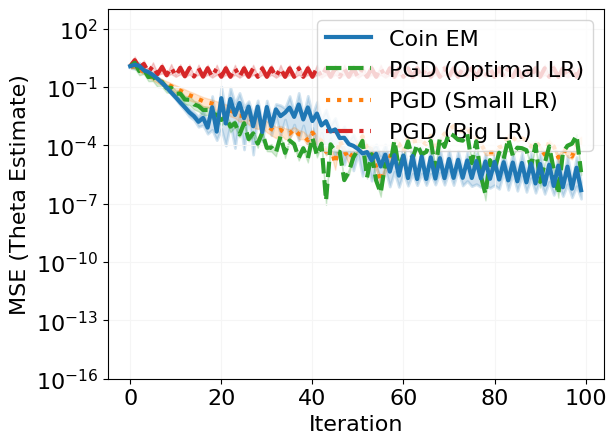

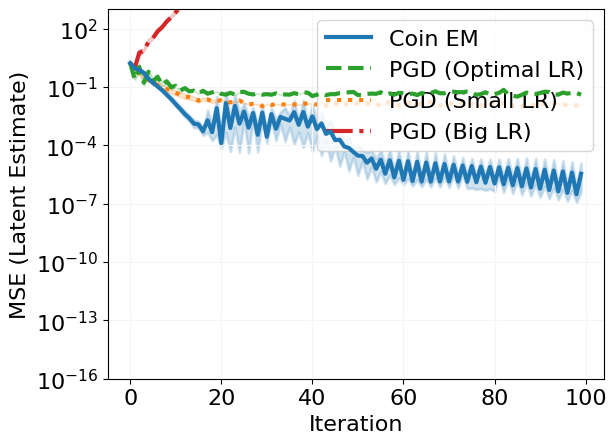

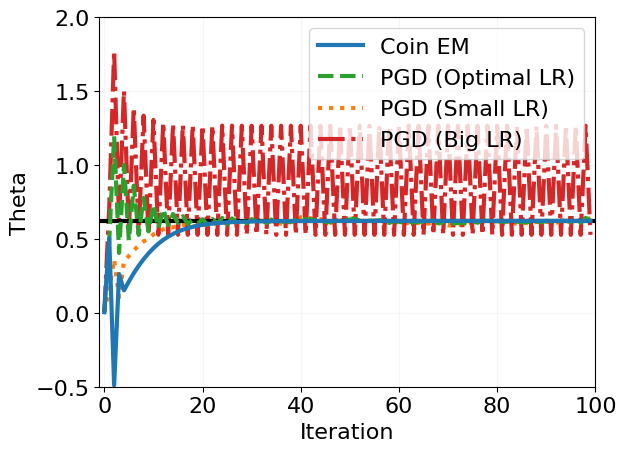

In [46]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_ada_pgd = np.mean(mse_ada_pgd_all,axis=0) # mean over reps
mse_ada_pgd_small = np.mean(mse_ada_pgd_all_small,axis=0) # mean over reps
mse_ada_pgd_big = np.mean(mse_ada_pgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_pgd_small = (mse_ada_pgd_all_small,)  # samples must be in a sequence
res_ada_pgd_small = bootstrap(data_ada_pgd_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (mse_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_ada_pgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_ada_pgd, zorder=8, color="C2", label="PGD (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_ada_pgd_small, color="C1", label="PGD (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd_small.confidence_interval[0], res_ada_pgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_ada_pgd_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_pgd_big.confidence_interval[0], res_ada_pgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Theta Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

    
save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_theta_mse_pgd_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()



# Plot MSE (latent) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_ada_pgd = np.mean(mse_latent_ada_pgd_all,axis=0) # mean over reps
mse_latent_ada_pgd_small = np.mean(mse_latent_ada_pgd_all_small,axis=0) # mean over reps
mse_latent_ada_pgd_big = np.mean(mse_latent_ada_pgd_all_big,axis=0) # mean over reps

# compute confidence intervals

data_ada_pgd = (mse_latent_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_pgd_small = (mse_latent_ada_pgd_all_small,)  # samples must be in a sequence
res_ada_pgd_small = bootstrap(data_ada_pgd_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (mse_latent_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_ada_pgd_big, np.mean, confidence_level=0.9)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_ada_pgd, zorder=8, color="C2", label="PGD (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_ada_pgd_small, color="C1", label="PGD (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_ada_pgd_small.confidence_interval[0], res_ada_pgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_ada_pgd_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_ada_pgd_big.confidence_interval[0], res_ada_pgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Latent Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

    
save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_latent_mse_pgd_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()



# Plot theta vs iterations (illustrative run)

#th_coin = np.mean(th_coin_all, axis=0)
#th_svgd = np.mean(th_ada_svgd_all,axis=0) # mean over reps
#th_svgd_small = np.mean(th_ada_svgd_all_small,axis=0) # mean over reps
#th_svgd_big = np.mean(th_ada_svgd_all_big,axis=0) # mean over reps
th_coin = th_coin_all[which_rep,:]
th_pgd = th_ada_pgd_all[which_rep,:]
th_pgd_small = th_ada_pgd_all_small[which_rep,:]
th_pgd_big = th_ada_pgd_all_big[which_rep,:]

# compute confidence intervals

data_ada_pgd = (th_ada_pgd_all,)  # samples must be in a sequence
res_ada_pgd = bootstrap(data_ada_pgd, np.mean, confidence_level=0.9)

data_ada_pgd_small = (th_ada_pgd_all_small,)  # samples must be in a sequence
res_ada_pgd_small = bootstrap(data_ada_pgd_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (th_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_ada_pgd_big, np.mean, confidence_level=0.9)

data_coin = (th_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), th_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
#plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), th_pgd, zorder=8, color="C2", label="PGD (Optimal LR)", linestyle="dashed", linewidth=3)
#plt.fill_between(range(K), res_ada_pgd.confidence_interval[0], res_ada_pgd.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), th_pgd_small, color="C1", label="PGD (Small LR)", linestyle="dotted", linewidth=3)
#plt.fill_between(range(K), res_ada_pgd_small.confidence_interval[0], res_ada_pgd_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), th_pgd_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)
#plt.fill_between(range(K), res_ada_pgd_big.confidence_interval[0], res_ada_pgd_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("Theta", fontsize=16)
plt.axhline(theta_star_all[which_rep], color="black", linewidth=3, zorder=2)
#plt.yscale("log")
plt.xlim([-1,100]) # just plot first 100 iterations
plt.ylim(-.5,2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

save = True
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_theta_pgd_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()

### (b) SOUL vs Coin EM (Different LRs)

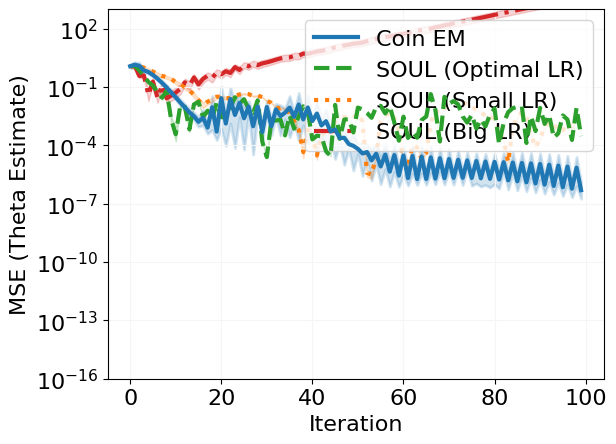

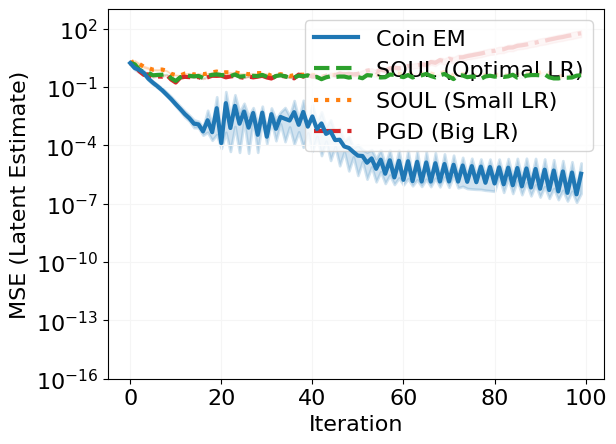

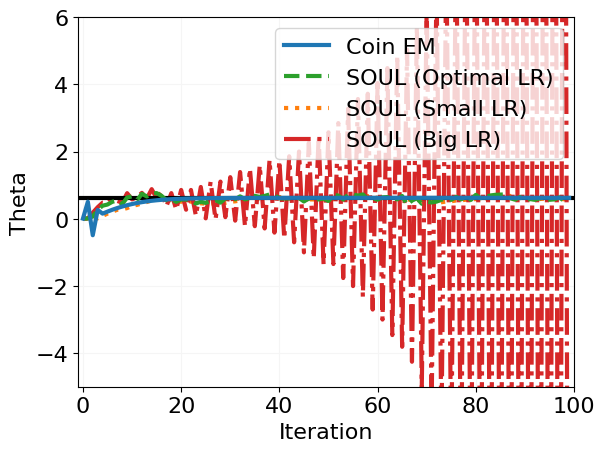

In [47]:
# Plot MSE (theta) vs iterations

mse_coin = np.mean(mse_coin_all, axis=0)
mse_soul = np.mean(mse_soul_all,axis=0) # mean over reps
mse_soul_small = np.mean(mse_soul_all_small,axis=0) # mean over reps
mse_soul_big = np.mean(mse_soul_all_big,axis=0) # mean over reps

# compute confidence intervals

data_soul = (mse_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_soul_small = (mse_soul_all_small,)  # samples must be in a sequence
res_soul_small = bootstrap(data_soul_small, np.mean, confidence_level=0.9)

data_soul_big = (mse_soul_all_big,)  # samples must be in a sequence
res_soul_big = bootstrap(data_soul_big, np.mean, confidence_level=0.9)

data_coin = (mse_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_soul, zorder=8, color="C2", label="SOUL (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_soul_small, color="C1", label="SOUL (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_soul_small.confidence_interval[0], res_soul_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_soul_big, color="C3", label="SOUL (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul_big.confidence_interval[0], res_soul_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Theta Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
    
save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_theta_mse_soul_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()



# Plot MSE (latent) vs iterations

mse_latent_coin = np.mean(mse_latent_coin_all, axis=0)
mse_latent_soul = np.mean(mse_latent_soul_all,axis=0) # mean over reps
mse_latent_soul_small = np.mean(mse_latent_soul_all_small,axis=0) # mean over reps
mse_latent_soul_big = np.mean(mse_latent_soul_all_big,axis=0) # mean over reps

# compute confidence intervals

data_soul = (mse_latent_soul_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_soul_small = (mse_latent_soul_all_small,)  # samples must be in a sequence
res_soul_small = bootstrap(data_soul_small, np.mean, confidence_level=0.9)

data_soul_big = (mse_latent_soul_all_big,)  # samples must be in a sequence
res_soul_big = bootstrap(data_soul_big, np.mean, confidence_level=0.9)

data_coin = (mse_latent_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), mse_latent_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), mse_latent_soul, zorder=8, color="C2", label="SOUL (Optimal LR)", linestyle="dashed", linewidth=3)
plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), mse_latent_soul_small, color="C1", label="SOUL (Small LR)", linestyle="dotted", linewidth=3)
plt.fill_between(range(K), res_soul_small.confidence_interval[0], res_soul_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), mse_latent_soul_big, color="C3", label="PGD (Big LR)", linestyle='dashdot', linewidth=3)
plt.fill_between(range(K), res_soul_big.confidence_interval[0], res_soul_big.confidence_interval[1], color="C3", alpha=0.2)

plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("MSE (Latent Estimate)", fontsize=16)
plt.yscale("log")
plt.ylim(1e-16,10e2)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

save = False
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_latent_mse_soul_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()



# Plot theta vs iterations (illustrative run)

#th_coin = np.mean(th_coin_all, axis=0)
#th_soul = np.mean(th_soul_all,axis=0) # mean over reps
#th_soul_small = np.mean(th_soul_all_small,axis=0) # mean over reps
#th_soul_big = np.mean(th_soul_all_big,axis=0) # mean over reps
th_coin = th_coin_all[which_rep,:]
th_soul = th_soul_all[which_rep,:]
th_soul_small = th_soul_all_small[which_rep,:]
th_soul_big = th_soul_all_big[which_rep,:]

# compute confidence intervals

data_soul = (th_ada_pgd_all,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

data_soul_small = (th_ada_pgd_all_small,)  # samples must be in a sequence
res_soul_small = bootstrap(data_soul_small, np.mean, confidence_level=0.9)

data_ada_pgd_big = (th_ada_pgd_all_big,)  # samples must be in a sequence
res_ada_pgd_big = bootstrap(data_soul_big, np.mean, confidence_level=0.9)

data_coin = (th_coin_all,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

plt.plot(range(K), th_coin, color="C0", zorder=10, label="Coin EM", linewidth=3)
#plt.fill_between(range(K), res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2, linewidth=2)

plt.plot(range(K), th_soul, zorder=8, color="C2", label="SOUL (Optimal LR)", linestyle="dashed", linewidth=3)
#plt.fill_between(range(K), res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C2", alpha=0.2)

plt.plot(range(K), th_soul_small, color="C1", label="SOUL (Small LR)", linestyle="dotted", linewidth=3)
#plt.fill_between(range(K), res_soul_small.confidence_interval[0], res_soul_small.confidence_interval[1], color="C1", alpha=0.2)

plt.plot(range(K), th_soul_big, color="C3", label="SOUL (Big LR)", linestyle='dashdot', linewidth=3)
#plt.fill_between(range(K), res_soul_big.confidence_interval[0], res_soul_big.confidence_interval[1], color="C3", alpha=0.2)


plt.legend(loc='upper right',prop={'size': 16})
plt.xlabel('Iteration', fontsize=16)
plt.ylabel("Theta", fontsize=16)
plt.axhline(theta_star_all[which_rep], color="black", linewidth=3, zorder=2)
#plt.yscale("log")
plt.xlim([-1,100]) # just plot first 100 iterations
plt.ylim(-5,6)
plt.grid(color='whitesmoke')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

    
save = True
if save:
    plt.savefig(fig_dir + "/" + "toy_iter_vs_theta_soul_different_lr" + result_id + ".pdf", dpi=300, bbox_inches='tight')

plt.show()

# Experiment 2 (Bias investigation)

We now consider a single latent dimension. For which, the optimal posterior variance can be shown to be 1/2. We start by running some repeats for Coin SVGD, EM SVGD, and PGD.

In [56]:
from coinem.zoo import coin_svgd, ada_svgd, soul, pgd, ada_pgd, standard_svgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_ada_svgd, marginal_soul, marginal_pgd

# # Run all methods for grid of step sizes
results_dir = "results/toy_model/experiment2"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
K = 5000  # Number of steps.

Ny = 1
Dy = 1
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

data = Dataset(y=y)

reps = 10
N_list = [2, 5, 10, 20, 50, 100]

load = True
if load:
    x_coin_all_list = np.load(results_dir + "/" + "var_exp_x_coin_all" + ".npz")
    x_svgd_all_list = np.load(results_dir + "/" + "var_exp_x_svgd_all" + ".npz")
    x_pgd_all_list = np.load(results_dir + "/" + "var_exp_x_pgd_all" + ".npz")
    
    th_coin_all_list = np.load(results_dir + "/" + "var_exp_th_coin_all" + ".npz")
    th_svgd_all_list = np.load(results_dir + "/" + "var_exp_th_svgd_all" + ".npz")
    th_pgd_all_list = np.load(results_dir + "/" + "var_exp_th_pgd_all" + ".npz")

    
else: 
    x_coin_all_list, th_coin_all_list = [], []
    x_svgd_all_list, th_svgd_all_list = [], []
    x_pgd_all_list, th_pgd_all_list = [], []

    for i, N in enumerate(N_list):

        print("N value: " + str(i+1) + "/" + str(len(N_list)))

        x_coin_all, th_coin_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
        x_svgd_all, th_svgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
        x_pgd_all, th_pgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))

        for j, rep in enumerate(range(reps)):
            
            print("Repetition: " + str(j+1) + "/" + str(reps))

            key, subkey = jr.split(key)
            th0 = 1 + jr.normal(subkey, (1,)) # initial parameter guess.
            X0 = jr.normal(subkey, (N, Dy))  # initial particle cloud.

            model = HierarchicalModel()

            # Run methods
            x_coin, th_coin = coin_svgd(model, data, X0, th0, K) 
            x_svgd, th_svgd = ada_svgd(model, data, X0, th0, K, latent_step_size=1, theta_step_size=1)
            x_pgd, th_pgd = ada_pgd(model, data, X0, th0, K)

            x_coin_all[j, :, :], th_coin_all[j, :] = x_coin, th_coin.squeeze()
            x_svgd_all[j, :, :], th_svgd_all[j, :] = x_svgd, th_svgd.squeeze()
            x_pgd_all[j, :, :], th_pgd_all[j, :] = x_pgd, th_pgd.squeeze()

        x_coin_all_list.append(x_coin_all)
        th_coin_all_list.append(th_coin_all)

        x_svgd_all_list.append(x_svgd_all)
        th_svgd_all_list.append(th_svgd_all)

        x_pgd_all_list.append(x_pgd_all)
        th_pgd_all_list.append(th_pgd_all)

    save = True
    if save:
        np.savez(results_dir + "/" + "var_exp_x_coin_all", *x_coin_all_list)
        np.savez(results_dir + "/" + "var_exp_x_svgd_all", *x_svgd_all_list)
        np.savez(results_dir + "/" + "var_exp_x_pgd_all", *x_pgd_all_list)

        np.savez(results_dir + "/" + "var_exp_th_coin_all", *th_coin_all_list)
        np.savez(results_dir + "/" + "var_exp_th_svgd_all", *th_svgd_all_list)
        np.savez(results_dir + "/" + "var_exp_th_pgd_all", *th_pgd_all_list)

Let's plot the results. First we'll compute the variance by averaging over time and over the particles. It seems coin tends to underestimate the variance, for smaller numbers of particles.

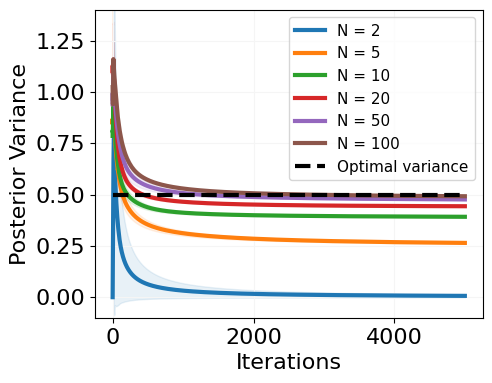

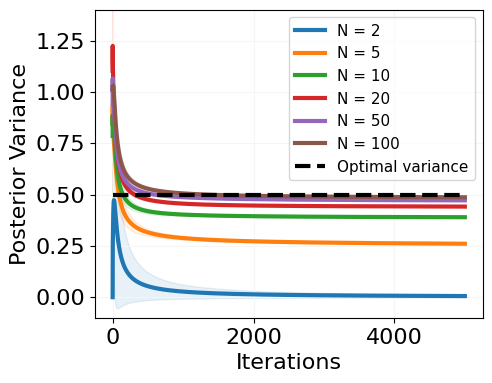

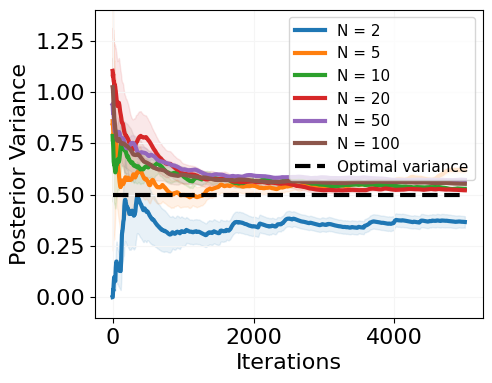

In [57]:
import copy

# Set up directory
fig_dir = "figures/toy_model"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
    
fig1, ax1 = plt.subplots(1, figsize=(5,4))
fig2, ax2 = plt.subplots(1, figsize=(5,4))
fig3, ax3 = plt.subplots(1, figsize=(5,4))
for i, N in enumerate(N_list):
    
    if load:
        x_coin_all = x_coin_all_list['arr_{}'.format(i)]
        x_svgd_all = x_svgd_all_list['arr_{}'.format(i)]
        x_pgd_all = x_pgd_all_list['arr_{}'.format(i)]
    else:
        x_coin_all = x_coin_all_list[i]
        x_svgd_all = x_svgd_all_list[i]
        x_pgd_all = x_pgd_all_list[i]

    
    #x_pgd_all_tmp_1 = copy.deepcopy(x_pgd_all_tmp.squeeze(-1))
    #x_pgd_all_tmp_2 = copy.deepcopy(x_pgd_all_tmp.squeeze(-1))
    #k_b=K
    #for j in range(k_b,K):
    #    x_pgd_all_tmp_2[:,j,:] = np.sum(x_pgd_all_tmp_1[:,k_b:(j+1),:],axis=1)/(j+1-k_b)
    #print(x_pgd_all[0,:,0])
    #x_pgd_all = copy.deepcopy(x_pgd_all_tmp_2)
    #plt.plot(x_pgd_all_tmp[0,:,0])
    #plt.plot(x_pgd_all[0,:,0])
    #plt.show()
    
    
    #mu1_coin = x_coin_all.mean(axis=2) ** 2 # E[x]^2, expectation over particles
    mu1_coin = x_coin_all.mean(axis=2)
    mu2_coin = (x_coin_all ** 2).mean(axis=2) # E[x^2], expectation over particles
    #var_coin = (mu2_coin - mu1_coin).squeeze() # Var(x)
    var_coin = ((jnp.cumsum(mu2_coin.squeeze(), axis=1)/jnp.arange(1, K + 1)
            - (jnp.cumsum(mu1_coin.squeeze(), axis=1)/jnp.arange(1, K + 1)) ** 2))
    var_coin_mean = var_coin.mean(axis=0) # average over reps
    var_coin_std = var_coin.std(axis=0) # std over reps
    
    #mu1_svgd = x_svgd_all.mean(axis=2) ** 2
    mu1_svgd = x_svgd_all.mean(axis=2) 
    mu2_svgd = (x_svgd_all ** 2).mean(axis=2)
    #var_svgd = (mu2_svgd - mu1_svgd).squeeze() # Var(x)
    var_svgd = ((jnp.cumsum(mu2_svgd.squeeze(), axis=1)/jnp.arange(1, K + 1)
            - (jnp.cumsum(mu1_svgd.squeeze(), axis=1)/jnp.arange(1, K + 1)) ** 2))
    var_svgd_mean = var_svgd.mean(axis=0)
    var_svgd_std = var_svgd.std(axis=0)
    
    mu1_pgd = x_pgd_all.mean(axis=2)
    mu2_pgd = (x_pgd_all ** 2).mean(axis=2)
    var_pgd = ((jnp.cumsum(mu2_pgd.squeeze(), axis=1)/jnp.arange(1, K + 1)
            - (jnp.cumsum(mu1_pgd.squeeze(), axis=1)/jnp.arange(1, K + 1)) ** 2))
    var_pgd_mean = var_pgd.mean(axis=0)
    var_pgd_std = var_pgd.std(axis=0)

    ax1.plot(range(K), var_coin_mean, label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax1.fill_between(range(K), var_coin_mean - var_coin_std, var_coin_mean + var_coin_std, color="C" + str(i), alpha=0.1)
    ax2.plot(range(K), var_svgd_mean, label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax2.fill_between(range(K), var_svgd_mean - var_svgd_std, var_svgd_mean + var_svgd_std, color="C" + str(i), alpha=0.1)
    ax3.plot(range(K), var_pgd_mean, label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax3.fill_between(range(K), var_pgd_mean - var_pgd_std, var_pgd_mean + var_pgd_std, color="C" + str(i), alpha=0.1)

#plt.ylim(1e-8,1.0)
#plt.yscale("log")


ax1.grid(color="whitesmoke")
ax2.grid(color='whitesmoke')
ax3.grid(color='whitesmoke')
ax1.set_xlabel("Iterations", fontsize=16)
ax2.set_xlabel("Iterations", fontsize=16)
ax3.set_xlabel("Iterations", fontsize=16)
ax1.set_ylabel("Posterior Variance", fontsize=16)
ax2.set_ylabel("Posterior Variance", fontsize=16)
ax3.set_ylabel("Posterior Variance", fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax3.tick_params(axis='both', labelsize=16)
ax1.set_ylim(-0.1,1.4)
ax2.set_ylim(-0.1,1.4)
ax3.set_ylim(-0.1,1.4)
ax1.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax2.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax3.hlines(0.5, 0, K, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax1.legend(loc='upper right', prop={'size': 11})
ax2.legend(loc='upper right', prop={'size': 11})
ax3.legend(loc='upper right', prop={'size': 11})

fig1.savefig(fig_dir + "/" + "toy_" + "var_exp_coin_average.pdf", dpi=300, bbox_inches="tight")
fig2.savefig(fig_dir + "/" + "toy_" + "var_exp_svgd_average.pdf", dpi=300, bbox_inches="tight")
fig3.savefig(fig_dir + "/" + "toy_" + "var_exp_pgd_average.pdf", dpi=300, bbox_inches="tight")




Now we repeat the same calculations, but this time not averaging over time.

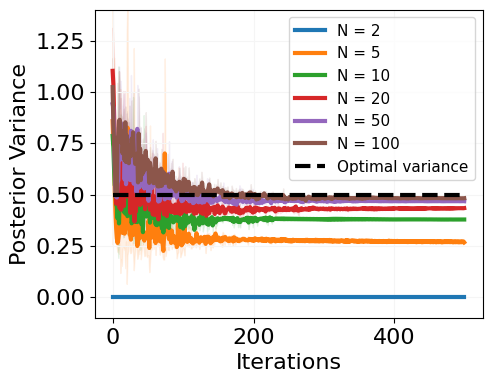

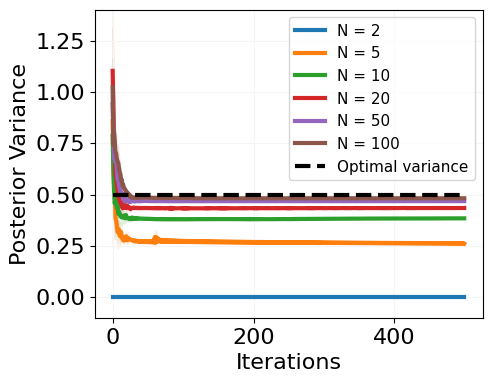

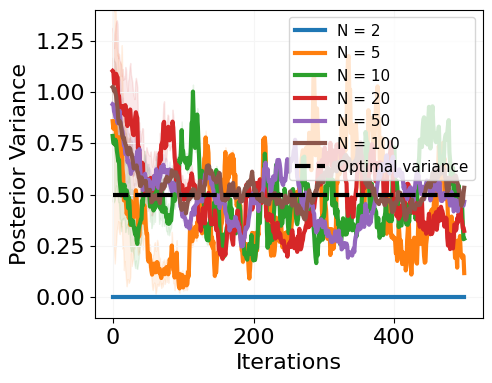

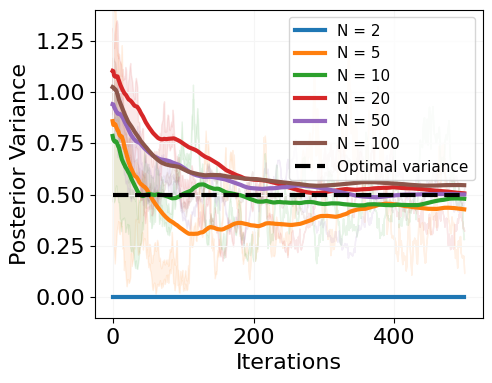

In [59]:
import copy

# Set up directory
fig_dir = "figures/toy_model"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
    
fig1, ax1 = plt.subplots(1, figsize=(5,4))
fig2, ax2 = plt.subplots(1, figsize=(5,4))
fig3, ax3 = plt.subplots(1, figsize=(5,4))
fig4, ax4 = plt.subplots(1, figsize=(5,4))
for i, N in enumerate(N_list):
    
    if load:
        x_coin_all = x_coin_all_list['arr_{}'.format(i)]
        x_svgd_all = x_svgd_all_list['arr_{}'.format(i)]
        x_pgd_all = x_pgd_all_list['arr_{}'.format(i)]
    else:
        x_coin_all = x_coin_all_list[i]
        x_svgd_all = x_svgd_all_list[i]
        x_pgd_all = x_pgd_all_list[i]

    
    #x_pgd_all_tmp_1 = copy.deepcopy(x_pgd_all_tmp.squeeze(-1))
    #x_pgd_all_tmp_2 = copy.deepcopy(x_pgd_all_tmp.squeeze(-1))
    #k_b=K
    #for j in range(k_b,K):
    #    x_pgd_all_tmp_2[:,j,:] = np.sum(x_pgd_all_tmp_1[:,k_b:(j+1),:],axis=1)/(j+1-k_b)
    #print(x_pgd_all[0,:,0])
    #x_pgd_all = copy.deepcopy(x_pgd_all_tmp_2)
    #plt.plot(x_pgd_all_tmp[0,:,0])
    #plt.plot(x_pgd_all[0,:,0])
    #plt.show()
    
    
    mu1_coin = x_coin_all.mean(axis=2) ** 2 # E[x]^2, expectation over particles
    mu2_coin = (x_coin_all ** 2).mean(axis=2) # E[x^2], expectation over particles
    var_coin = (mu2_coin - mu1_coin).squeeze() # Var(x)
    var_coin_mean = var_coin.mean(axis=0) # average over reps
    var_coin_std = var_coin.std(axis=0) # std over reps
    
    mu1_svgd = x_svgd_all.mean(axis=2) ** 2
    mu2_svgd = (x_svgd_all ** 2).mean(axis=2)
    var_svgd = (mu2_svgd - mu1_svgd).squeeze() # Var(x)
    var_svgd_mean = var_svgd.mean(axis=0)
    var_svgd_std = var_svgd.std(axis=0)
    
    mu1_pgd = x_pgd_all.mean(axis=2) ** 2
    mu2_pgd = (x_pgd_all ** 2).mean(axis=2)
    var_pgd = (mu2_pgd - mu1_pgd).squeeze() # Var(x)
    var_pgd_mean = var_pgd.mean(axis=0)
    var_pgd_std = var_pgd.std(axis=0)

    K_plot = 500
    ax1.plot(range(K_plot), var_coin_mean[:K_plot], label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax1.fill_between(range(K_plot), var_coin_mean[:K_plot] - var_coin_std[:K_plot], var_coin_mean[:K_plot] + var_coin_std[:K_plot], color="C" + str(i), alpha=0.1)
    ax2.plot(range(K_plot), var_svgd_mean[:K_plot], label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax2.fill_between(range(K_plot), var_svgd_mean[:K_plot] - var_svgd_std[:K_plot], var_svgd_mean[:K_plot] + var_svgd_std[:K_plot], color="C" + str(i), alpha=0.1)
    ax3.plot(range(K_plot), var_pgd_mean[:K_plot], label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax3.fill_between(range(K_plot), var_pgd_mean[:K_plot] - var_pgd_std[:K_plot], var_pgd_mean[:K_plot] + var_pgd_std[:K_plot], color="C" + str(i), alpha=0.1)
    ax4.plot(range(K_plot), np.cumsum(var_pgd_mean[:K_plot])/np.arange(1,K_plot+1), label='N = {}'.format(N), color="C" + str(i), linewidth=3)
    ax4.fill_between(range(K_plot), var_pgd_mean[:K_plot] - var_pgd_std[:K_plot], var_pgd_mean[:K_plot] + var_pgd_std[:K_plot], color="C" + str(i), alpha=0.1)
    
#plt.ylim(1e-8,1.0)
#plt.yscale("log")

ax1.grid(color="whitesmoke")
ax2.grid(color='whitesmoke')
ax3.grid(color='whitesmoke')
ax4.grid(color='whitesmoke')
ax1.set_xlabel("Iterations", fontsize=16)
ax2.set_xlabel("Iterations", fontsize=16)
ax3.set_xlabel("Iterations", fontsize=16)
ax4.set_xlabel("Iterations", fontsize=16)
ax1.set_ylabel("Posterior Variance", fontsize=16)
ax2.set_ylabel("Posterior Variance", fontsize=16)
ax3.set_ylabel("Posterior Variance", fontsize=16)
ax4.set_ylabel("Posterior Variance", fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax3.tick_params(axis='both', labelsize=16)
ax4.tick_params(axis='both', labelsize=16)
ax1.set_ylim(-0.1,1.4)
ax2.set_ylim(-0.1,1.4)
ax3.set_ylim(-0.1,1.4)
ax4.set_ylim(-0.1,1.4)
ax1.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax2.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax3.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax4.hlines(0.5, 0, K_plot, label='Optimal variance', linestyles='dashed', color='black', linewidth=3)
ax1.legend(loc='upper right', prop={'size': 11})
ax2.legend(loc='upper right', prop={'size': 11})
ax3.legend(loc='upper right', prop={'size': 11})
ax4.legend(loc='upper right', prop={'size': 11})

fig1.savefig(fig_dir + "/" + "toy_" + "var_exp_coin_non_average.pdf", dpi=300, bbox_inches="tight")
fig2.savefig(fig_dir + "/" + "toy_" + "var_exp_svgd_non_average.pdf", dpi=300, bbox_inches="tight")
fig3.savefig(fig_dir + "/" + "toy_" + "var_exp_pgd_non_average.pdf", dpi=300, bbox_inches="tight")
fig4.savefig(fig_dir + "/" + "toy_" + "var_exp_pgd_non_average_smooth.pdf", dpi=300, bbox_inches="tight")



In [62]:
from coinem.zoo import coin_svgd, ada_svgd, soul, pgd, ada_pgd, standard_svgd
from coinem.marginal_zoo import marginal_coin_svgd, marginal_ada_svgd, marginal_soul, marginal_pgd

# # Run all methods for grid of step sizes
results_dir = "results/toy_model/experiment2"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
key = jr.PRNGKey(123)
K = 250  # Number of steps.

Ny = 1
Dy = 1
key = jr.PRNGKey(42)
theta = jnp.array([1.0])

key_y, key_latent = jr.split(key)
latent = theta + jr.normal(key_latent, (1, Dy))
y = jr.normal(key_y, (Ny, Dy)) + latent

data = Dataset(y=y)

N = 50

reps = 5

lr_list = np.logspace(-8,3,20)

load = True
if load:
    x_coin_all_list_lr = np.load(results_dir + "/" + "var_exp_x_coin_all_lr" + ".npz")
    x_svgd_all_list_lr = np.load(results_dir + "/" + "var_exp_x_svgd_all_lr" + ".npz")
    x_pgd_all_list_lr = np.load(results_dir + "/" + "var_exp_x_pgd_all_lr" + ".npz")
    x_soul_all_list_lr = np.load(results_dir + "/" + "var_exp_x_soul_all_lr" + ".npz")
    
    th_coin_all_list_lr = np.load(results_dir + "/" + "var_exp_th_coin_all_lr" + ".npz")
    th_svgd_all_list_lr = np.load(results_dir + "/" + "var_exp_th_svgd_all_lr" + ".npz")
    th_pgd_all_list_lr = np.load(results_dir + "/" + "var_exp_th_pgd_all_lr" + ".npz")
    th_soul_all_list_lr = np.load(results_dir + "/" + "var_exp_th_soul_all_lr" + ".npz")
    
else: 
    x_coin_all_list_lr, th_coin_all_list_lr = [], []
    x_svgd_all_list_lr, th_svgd_all_list_lr = [], []
    x_pgd_all_list_lr, th_pgd_all_list_lr = [], []
    x_soul_all_list_lr, th_soul_all_list_lr = [], []

    for i, lr in enumerate(lr_list):

        print("LR value: " + str(i+1) + "/" + str(len(lr_list)))

        x_coin_all, th_coin_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
        x_svgd_all, th_svgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
        x_pgd_all, th_pgd_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))
        x_soul_all, th_soul_all = np.zeros((reps, K, N, Dy)), np.zeros((reps, K))

        for j, rep in enumerate(range(reps)):
            
            print("Repetition: " + str(j+1) + "/" + str(reps))

            key, subkey = jr.split(key)
            th0 = 1 + jr.normal(subkey, (1,)) # initial parameter guess.
            X0 = jr.normal(subkey, (N, Dy))  # initial particle cloud.

            model = HierarchicalModel()

            # Run methods
            x_coin, th_coin = coin_svgd(model, data, X0, th0, K) 
            x_svgd, th_svgd = ada_svgd(model, data, X0, th0, K, latent_step_size=lr, theta_step_size=lr)
            x_pgd, th_pgd = ada_pgd(model, data, X0, th0, K, latent_step_size=lr, theta_step_size=lr)
            x_soul, th_soul = soul(model, data, X0, th0, K, latent_step_size=lr, theta_step_size=lr)

            x_coin_all[j, :, :], th_coin_all[j, :] = x_coin, th_coin.squeeze()
            x_svgd_all[j, :, :], th_svgd_all[j, :] = x_svgd, th_svgd.squeeze()
            x_pgd_all[j, :, :], th_pgd_all[j, :] = x_pgd, th_pgd.squeeze()
            x_soul_all[j, :, :], th_soul_all[j, :] = x_soul, th_soul.squeeze()

        x_coin_all_list_lr.append(x_coin_all)
        th_coin_all_list_lr.append(th_coin_all)

        x_svgd_all_list_lr.append(x_svgd_all)
        th_svgd_all_list_lr.append(th_svgd_all)

        x_pgd_all_list_lr.append(x_pgd_all)
        th_pgd_all_list_lr.append(th_pgd_all)
        
        x_soul_all_list_lr.append(x_soul_all)
        th_soul_all_list_lr.append(th_soul_all)

    save = True
    if save:
        np.savez(results_dir + "/" + "var_exp_x_coin_all_lr", *x_coin_all_list_lr)
        np.savez(results_dir + "/" + "var_exp_x_svgd_all_lr", *x_svgd_all_list_lr)
        np.savez(results_dir + "/" + "var_exp_x_pgd_all_lr", *x_pgd_all_list_lr)
        np.savez(results_dir + "/" + "var_exp_x_soul_all_lr", *x_soul_all_list_lr)

        np.savez(results_dir + "/" + "var_exp_th_coin_all_lr", *th_coin_all_list_lr)
        np.savez(results_dir + "/" + "var_exp_th_svgd_all_lr", *th_svgd_all_list_lr)
        np.savez(results_dir + "/" + "var_exp_th_pgd_all_lr", *th_pgd_all_list_lr)
        np.savez(results_dir + "/" + "var_exp_th_soul_all_lr", *th_soul_all_list_lr)

Now we'll process and plot the results.

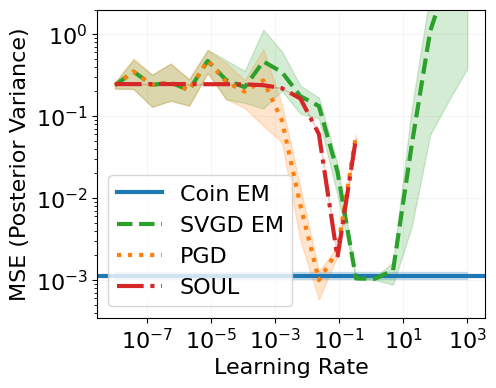

In [67]:
# Set up directory
fig_dir = "figures/toy_model"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
fig1, ax1 = plt.subplots(1, figsize=(5,4))

all_coin_var = np.zeros((reps, len(lr_list)))
all_svgd_var = np.zeros((reps, len(lr_list)))
all_pgd_var = np.zeros((reps, len(lr_list)))
all_soul_var = np.zeros((reps, len(lr_list)))

for i, N in enumerate(lr_list):
    
    if load:
        x_coin_all = x_coin_all_list_lr['arr_{}'.format(i)]
        x_svgd_all = x_svgd_all_list_lr['arr_{}'.format(i)]
        x_pgd_all = x_pgd_all_list_lr['arr_{}'.format(i)]
        x_soul_all = x_soul_all_list_lr['arr_{}'.format(i)]
    else:
        x_coin_all = x_coin_all_list_lr[i]
        x_svgd_all = x_svgd_all_list_lr[i]
        x_pgd_all = x_pgd_all_list_lr[i]
        x_soul_all = x_soul_all_list_lr[i]
    
    
    mu1_coin = x_coin_all.mean(axis=2) ** 2 # E[x]^2, expectation over particles
    mu2_coin = (x_coin_all ** 2).mean(axis=2) # E[x^2], expectation over particles
    var_coin = (mu2_coin - mu1_coin).squeeze() # Var(x)
    var_coin_final = var_coin[:,-1]
    
    mu1_svgd = x_svgd_all.mean(axis=2) ** 2
    mu2_svgd = (x_svgd_all ** 2).mean(axis=2)
    var_svgd = (mu2_svgd - mu1_svgd).squeeze() # Var(x)
    var_svgd_final = var_svgd[:,-1]
    
    mu1_pgd = x_pgd_all.mean(axis=2) ** 2
    mu2_pgd = (x_pgd_all ** 2).mean(axis=2)
    var_pgd = (mu2_pgd - mu1_pgd).squeeze() # Var(x)
    var_pgd_final = np.mean(var_pgd, axis=1)
    
    mu1_soul = x_soul_all.mean(axis=2) ** 2
    mu2_soul = (x_soul_all ** 2).mean(axis=2)
    var_soul = (mu2_soul - mu1_soul).squeeze() # Var(x)
    var_soul_final = np.mean(var_soul, axis=1)
    
    all_coin_var[:,i] = var_coin_final
    all_svgd_var[:,i] = var_svgd_final
    all_pgd_var[:,i] = var_pgd_final
    all_soul_var[:,i] = var_soul_final


mse_coin = ((all_coin_var - 0.5) ** 2).mean(axis=0)
mse_svgd = (all_svgd_var - 0.5) ** 2
mse_pgd = (all_pgd_var - 0.5) ** 2
mse_soul = (all_soul_var - 0.5) ** 2

data_coin = (mse_coin,)  # samples must be in a sequence
res_coin = bootstrap(data_coin, np.mean, confidence_level=0.9)

data_svgd = (mse_svgd,)  # samples must be in a sequence
res_svgd = bootstrap(data_svgd, np.mean, confidence_level=0.9)

data_pgd = (mse_pgd,)  # samples must be in a sequence
res_pgd = bootstrap(data_pgd, np.mean, confidence_level=0.9)

data_soul = (mse_soul,)  # samples must be in a sequence
res_soul = bootstrap(data_soul, np.mean, confidence_level=0.9)

plt.axhline(np.mean(mse_coin), color="C0", label="Coin EM", linewidth=3)
plt.fill_between(lr_list, res_coin.confidence_interval[0], res_coin.confidence_interval[1], color="C0", alpha=0.2)
plt.plot(lr_list, np.mean(mse_svgd,axis=0), color="C2", label="SVGD EM", linewidth=3, linestyle='dashed')
plt.fill_between(lr_list, res_svgd.confidence_interval[0], res_svgd.confidence_interval[1], color="C2", alpha=0.2)
plt.plot(lr_list, np.mean(mse_pgd,axis=0),  color="C1",label='PGD', linewidth=3, linestyle='dotted')
plt.fill_between(lr_list, res_pgd.confidence_interval[0], res_pgd.confidence_interval[1], color="C1", alpha=0.2)
plt.plot(lr_list, np.mean(mse_soul,axis=0), color="C3",label='SOUL', linewidth=3, linestyle='dashdot')
plt.fill_between(lr_list, res_soul.confidence_interval[0], res_soul.confidence_interval[1], color="C3", alpha=0.2)
plt.legend(prop={'size': 16})
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning Rate", fontsize=16)
plt.ylabel("MSE (Posterior Variance)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='whitesmoke')
ax1.set_axisbelow(True)
plt.ylim(0,2)

plt.savefig(fig_dir + "/" + "toy_" + "var_exp_lr_vs_mse.pdf", dpi=300, bbox_inches="tight")
